In [174]:
# import needed modules
import pandas as pd
from IPython.display import display_html
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
pd.set_option('display.max_columns', 100)
from datetime import datetime
import dataframe_image as dfi
import string

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
import itertools

### Helper functions

In [2]:
def excel_to_csv (excel_file_name, suffixe):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[[0,1,3]], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [3]:
def get_weight(pp_port, strategie, histo_date):
    return pp_port[(pp_port['strategie'] == strategie) & (pp_port['histo_date'] == histo_date)][['No ISIN', 'weight']]

In [4]:
def get_all_strat(pp_port, curr=None):
    if curr is not None:
        all_strat = list(pp_port[pp_port.strategie.str.contains(curr)]['strategie'].unique())
    else:
        all_strat = list(pp_port['strategie'].unique())
        
    return all_strat

In [5]:
def get_all_isin(pp_port, curr=None, histo_date=None, strat=None):
    if curr is not None:
        if histo_date is None:
            if strat is None:
                all_isin = pp_port[pp_port['strategie'].str.contains(curr)]
            else:
                all_isin = pp_port[(pp_port['strategie'] == strat) & (pp_port['strategie'].str.contains(curr))]
        else:
            all_isin = pp_port[(pp_port['histo_date'] == histo_date) & (pp_port['strategie'].str.contains(curr))]
    else:
        if histo_date is None:
            all_isin = pp_port[pp_port['strategie']]
        else:
            all_isin = pp_port[pp_port['histo_date'] == histo_date]
        
    return pd.DataFrame(all_isin['No ISIN'].unique(), columns=['No ISIN'])

In [6]:
def sigma_to_sharp (weights, assets_annual_ret, assets_annual_cov):
    
    port_ret = weights @ assets_annual_ret
    port_vol = np.sqrt(weights.T @ assets_annual_cov @ weights )
    port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [7]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'LEUPCBC SW Index',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'M0UKHEUR Index': 'UKEUBH B2 Equity',
    'M0EMHCHF Index': 'EMUC SW Equity',
    'M0CHHEUR Index': 'CHEURIV Index',
    'M0UKHCHF Index': 'UKCHFIV Index',
    'JPGCHFCP Index': 'EMBC SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index'
    }, inplace=True)
    
    # portfolio = portfolio[
    #    ~portfolio['No ISIN'].isin([
    #    'HFRXGLC Index', 'SWIIT Index', 'SF15T Index', 
    #    'M0EMHCHF Index', 'SBR4T Index', 'H20344CH Index', 'BXCHTRCH Index', 
    #    'SBF14T Index', 'BCOMHFT Index', 'LG30TRCH Index', 
    #    'aurlnchf curncy', 'M0UKHCHF Index', 'SF51T Index'])
    # ]
    portfolio = portfolio[
        ~portfolio['No ISIN'].isin([
        'HYBRIDCHF', 'SBWG10CH Index'])]
    return portfolio

In [8]:
def get_all_date(pp_port, strat):
    return pp_port[pp_port.strategie == strat]['histo_date'].unique()

### Historical price of underlying indices

In [9]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates', 'HYBRIDCHF', 'SBWG10CH Index'])

# Historical tactical portfolio

### filtering underlying price data with available isin

In [364]:
pp_port_excel = excel_to_csv('PP_data/pp_histo.xlsx', 'PP')
pp_port_excel.drop(columns='portfolio', inplace=True)

In [365]:
pp_port_excel = port_filter(pp_port_excel)

In [366]:
pp_port = pp_port_excel.copy()

In [12]:
pp_port['histo_date'].dt.strftime('%Y-%m-%d').unique()

array(['2019-10-11', '2019-11-13', '2019-12-13', '2020-01-16',
       '2020-02-13', '2020-03-12', '2020-04-16', '2020-05-14',
       '2020-06-10', '2020-07-16', '2020-08-20', '2020-09-17',
       '2020-10-16', '2020-11-12', '2020-12-10', '2021-01-21',
       '2021-02-26', '2021-03-17', '2021-04-19', '2021-05-18',
       '2021-06-17', '2021-08-18'], dtype=object)

In [337]:
date = '2020-01-16'
curr = 'CHF'

In [338]:
all_strategies = get_all_strat(pp_port, curr)
all_isin = get_all_isin(pp_port, curr=curr, histo_date=date)

In [339]:
data = data_excel.copy()

In [340]:
data = data[list(all_isin['No ISIN'])]

### Historical statistics simulation with underlying prices and random portfolios

In [341]:
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

In [342]:
num_assets = data.shape[1]
num_portfolios = 50000

Optimal Portfolio
SIGMA = cov_annual
INV_SIGMA = np.linalg.inv(SIGMA)
ONES = np.ones(num_assets)
MU = np.array(list(returns_annual))

A = (ONES @ INV_SIGMA) @ ONES
B = (ONES @ INV_SIGMA) @ MU
C = (MU @ INV_SIGMA) @ MU
DELTA = A * C - B**2

Mup = np.linspace(0.001,0.5,1000)
Sigmap = np.sqrt((A * np.multiply(Mup, Mup) - 2 * B * Mup + C) / DELTA)

In [343]:
# Random Portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []

for single_portfolio in tqdm(range(num_portfolios)):
    weights = np.random.choice(np.linspace(0,0.99,num_portfolios), num_assets)
    # weights = np.random.random(num_assets)
    weights = np.multiply(weights, np.random.binomial(1, 0.2, size=num_assets))
    if np.sum(weights) == 0:
        continue
    weights /= np.sum(weights)
    returns = weights @ returns_annual
    volatility = np.sqrt(weights.T @ cov_annual @ weights)
    if volatility == 0:
        continue
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)

100%|██████████| 50000/50000 [00:20<00:00, 2475.34it/s]


In [344]:
df = pd.DataFrame(data={'returns': port_returns,
                        'volatility': port_volatility,
                        'sharpe_ratio': sharpe_ratio})
df.returns = df.returns * 100
df.volatility = df.volatility * 100
df = df[(df.sharpe_ratio > -0.2) & (df.sharpe_ratio < 1.5) & (df.returns > -0.5)]

### Statistics of selected portfolios

#### Comparison between strategies

In [345]:
df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'strategie'])
date_port = date
for strat in all_strategies:
    portfolio = get_weight(pp_port, strat, date_port).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
    # print(strat)
    # print(portfolio)
    # print(portfolio.weight.sum())
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_port = df_port.append(df_temp)
df_port.returns = df_port.returns * 100
df_port.volatility = df_port.volatility * 100

In [346]:
# sns.palplot(sns.diverging_palette(220, 0, n=len(df_port)))

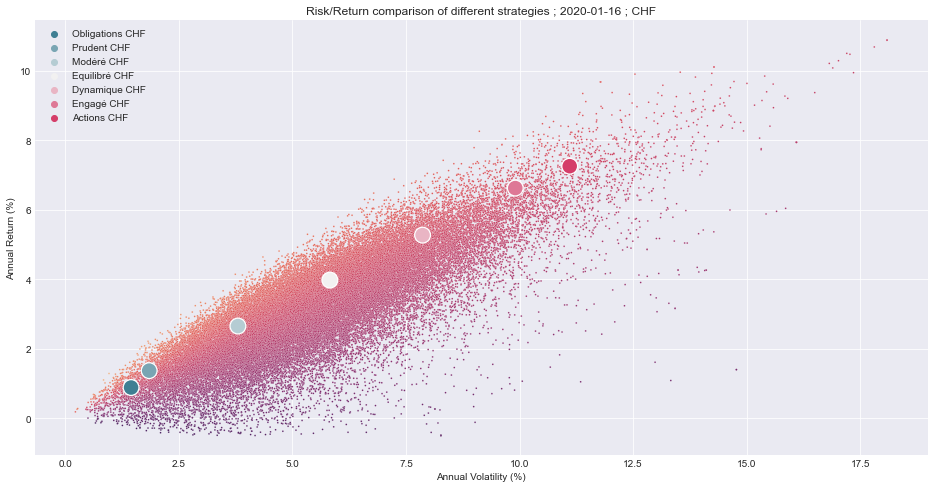

In [347]:
# seaborn plot
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
# sns.lineplot(x=Sigmap, y=Mup, sort=False, lw=1, palette="flare")
ax2.legend().set_title(None)
plt.title('Risk/Return comparison of different strategies ; ' + date + ' ; ' + curr)
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.savefig('pp_output/Comparison_' + curr + '_' + date + '.png')
plt.show()

#### risk/return time evolution of a strategie

In [275]:
curr = 'CHF'
strat = 'Equilibré' + ' ' +  curr
all_dates = get_all_date(pp_port, strat)
all_isin = get_all_isin(pp_port, curr=curr, strat=strat)

In [276]:
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]

In [277]:
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

In [278]:
df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
df_port_diff = pd.DataFrame(columns=['ISIN', 'weight_diff', 'date'])

for i, date in enumerate(all_dates[range(0, len(all_dates), 3)]):
    portfolio = get_weight(pp_port, strat, date).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
    df_port = df_port.append(df_temp)
    if i > 0:
        df_temp2 = pd.DataFrame(data={'ISIN':list(portfolio.index),'weight_diff': (portfolio.weight - temp_port.weight)})
        df_temp2['date'] = date
        df_port_diff = df_port_diff.append(df_temp2)
    temp_port = portfolio

df_port.date = df_port.date.dt.strftime('%d/%m/%Y')
# df_port = df_port.iloc[range(0, len(df_port), 3)]
df_port.volatility = df_port.volatility * 100
df_port.returns = df_port.returns * 100
df_port['diff_ret'] = df_port.returns.diff().shift(-1)
df_port['diff_vol'] = df_port.volatility.diff().shift(-1)
df_port.sharpe_ratio = df_port.sharpe_ratio.round(4)

# df_port_diff = df_port_diff[df_port_diff.date.isin(df_port.date)]
df_port.reset_index(inplace=True, drop=True)
df_port_diff.reset_index(inplace=True, drop=True)
index = pd.MultiIndex.from_frame(df_port_diff[['date', 'ISIN']])
df_port_diff = df_port_diff.set_index(index, drop=True).drop(columns=['ISIN', 'date'])
df_port_diff['weight_diff_abs'] = df_port_diff.weight_diff.abs()
df_port_diff['weight_diff'] = df_port_diff.weight_diff * 100

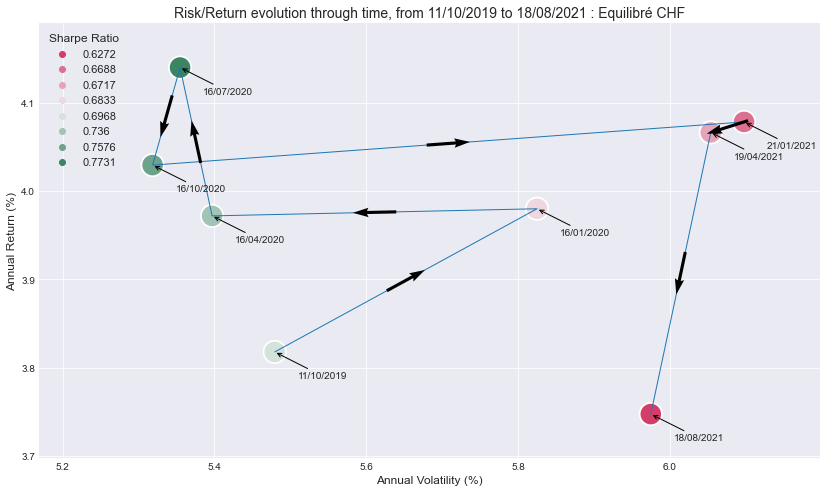

In [279]:
# seaborn plot
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(14,8))

ax = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.diverging_palette(0, 150, n=len(df_port)), s=500, legend=True)
sns.lineplot(data=df_port, x='volatility', y='returns', sort=False, lw=1, palette="flare", zorder=1, legend=False)
x = df_port['volatility']
y = df_port['returns']
dx = df_port['diff_vol']
dy = df_port['diff_ret']
pos_x = x[:-1] + dx/2
pos_y = y[:-1] + dy/2
norm = np.sqrt(dx**2 + dy**2) 
ax2 = plt.quiver(pos_x, pos_y, dx/norm, dy/norm, angles="xy", zorder=5, pivot="mid", width=0.004)
for index, row in df_port.iterrows():
    
    x = row['volatility']
    y = row['returns']
    dx = row['diff_vol']
    dy = row['diff_ret']
    
    ax3 = plt.annotate(row['date'], xy=(x, y), xytext=(x+0.03, y-0.03), 
                 arrowprops=dict(arrowstyle="->"), annotation_clip=True)
                 
    #ax3 = plt.arrow(x, y, dx, dy, width = 0.001, length_includes_head=True, overhang=0.5,
              #shape='full', head_starts_at_zero=False, head_width=0.015, head_length=0.02, color='steelblue')

ax.legend(loc='upper left', title='Sharpe Ratio', title_fontsize=12, fontsize=11)
plt.title(label=('Risk/Return evolution through time, from ' + df_port.date.iloc[0] + " to " + df_port.date.iloc[-1] + " : " + strat), fontsize=14)
plt.xlabel(xlabel='Annual Volatility (%)', fontsize=12)
plt.ylabel(ylabel='Annual Return (%)', fontsize=12)
plt.xlim(df_port.volatility.min() - 0.15, df_port.volatility.max() + 0.1,)
plt.ylim(df_port.returns.min() - 0.05, df_port.returns.max() + 0.05)
plt.savefig('pp_output/' + str.replace(strat, ' ', '') + '.png')
plt.grid()
plt.show()


In [348]:
# Export decision dataframe to PNG
df_diff = pd.DataFrame()
for i, (date, df) in enumerate(df_port_diff.groupby(level=0, group_keys=False)):
    df_top = df.nlargest(8, 'weight_diff_abs')['weight_diff'].to_frame().reset_index(drop=False).rename(columns={'weight_diff': 'Top Change'})
    df_top.columns = pd.MultiIndex.from_product([[df_top.date.iloc[0]], df_top.columns])
    df_top = df_top.drop('date', axis=1, level=1)
    df_diff = pd.concat([df_diff, df_top], axis=1)
dfi.export(df_diff, 'pp_output/TopMovers_' + str.replace(strat, ' ', '') + '.png')
df_diff

2020-01-16                  2020-04-16                 2020-07-16  \
             ISIN Top Change             ISIN Top Change            ISIN   
0    SBF14T Index      -8.56     NDDLUS Index      -3.79    NDDLUS Index   
1     SF15T Index       5.80   LGCPTRUU Index       3.21       SPI Index   
2  M0USHCHF Index      -4.50  AURLNCHF CURNCY       2.50      SMCI Index   
3   HFRXGLC Index      -3.50   M0USHEUR Index       2.30  M0USHEUR Index   
4   NDUEEGF Index       2.70   MSDEEMUN Index      -2.17     SF15T Index   
5  M1CXAMPF Index       2.00     NDDLJN Index       2.01     SF51T Index   
6     SWIIT Index       2.00   M0USHCHF Index       2.00  M0USHCHF Index   
7  M1US000V Index       1.80    HFRXGLC Index      -2.00  LF89TRCH Index   

                   2020-10-16                   2021-01-21             \
  Top Change             ISIN Top Change              ISIN Top Change   
0       7.09    HFRXGLC Index       2.00     HFRXGLC Index       4.50   
1      -4.20   SBWMUD3U Index      -2.00      NDDLUS Index      -4.13   
2       3.60   EMBC SW Equity      -1.97     NDUEEGF Index       3.85   
3      -3.50      SF51T Index       1.88    LGCPTRUU Index      -3.66   
4      -3.08       CHF Curncy       1.60    MSDEEMUN Index       3.41   
5       2.62  JPYUSDCR Curncy       1.60    SBWGNSZC Index       3.19   
6      -2.00   SBWMJY3L Index      -1.55    H00039CH Index       3.04   
7       1.97   H03410CH Index      -1.35  LEUPCBC SW Index      -3.00   

       2021-04-19                 2021-08-18             
             ISIN Top Change            ISIN Top Change  
0    NDDLUS Index      -3.43  NE734804 Index       3.65  
1    M1USMC Index       3.43  BXCHTRCH Index       3.53  
2   NDUEEGF Index      -1.71  MSDEEMUN Index      -3.44  
3    NDDLJN Index       1.71  SBWGNSZC Index      -3.19  
4  SBWMJY3L Index      -1.70  EMUC SW Equity       2.40  
5      SMCI Index      -1.66  M1CXAMPF Index      -2.00  
6  H00039CH Index       1.21     SF15T Index       1.83  
7  XGIUCHIV Index      -1.21      SMCI Index      -1.67

#### Comparison of risk/return decision between different strategies

In [282]:
curr = 'CHF'
all_strat = get_all_strat(pp_port, curr=curr)[1:]
# strat = 'Equilibré' + ' ' +  curr
all_dates = get_all_date(pp_port, strat)

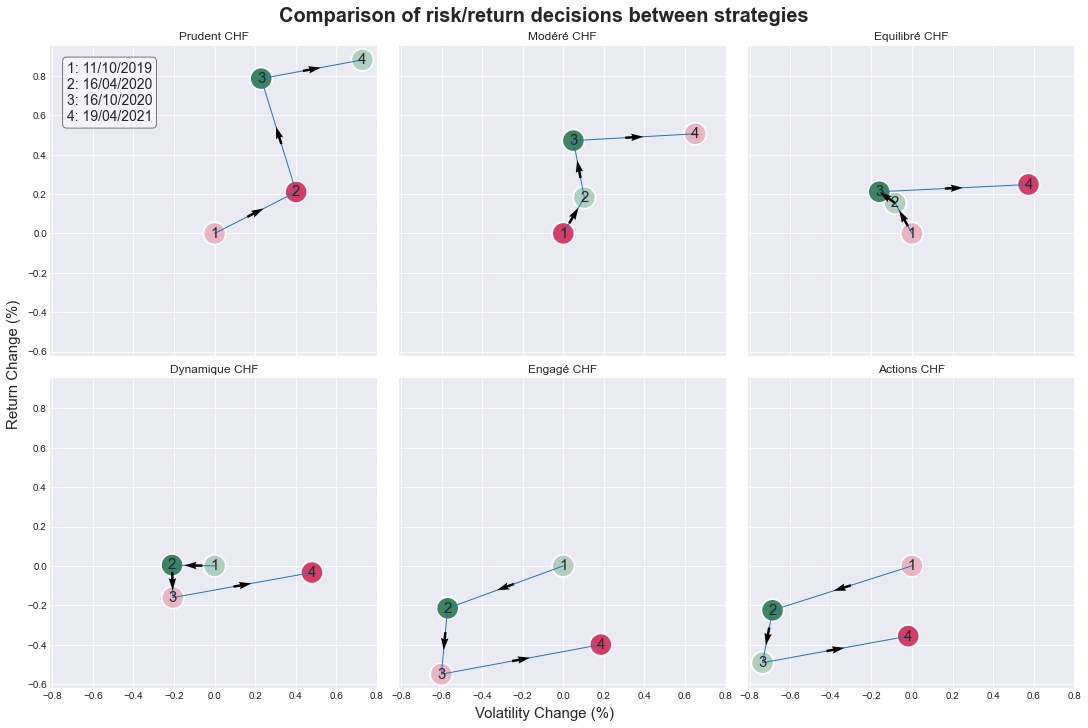

In [283]:
fig, axs = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

for i, strat in enumerate(all_strat):
    
    # DATA
    all_isin = get_all_isin(pp_port, curr=curr, strat=strat)
    data = data_excel.copy()
    data = data[list(all_isin['No ISIN'])]
    
    returns_daily = data.pct_change()
    returns_annual = returns_daily.mean() * 252
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 252
    
    df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
    
    for date in all_dates[range(0, len(all_dates), 6)]:
        portfolio = get_weight(pp_port, strat, date).reset_index(drop=True)
        portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
        portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
        weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
        port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
        df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
        df_port = df_port.append(df_temp)
        
    df_port.reset_index(inplace=True, drop=True)
    df_port.date = df_port.date.dt.strftime('%d/%m/%Y')
    df_port.volatility = df_port.volatility - df_port.volatility.iloc[0]
    df_port.returns = df_port.returns - df_port.returns.iloc[0]
    df_port.volatility = df_port.volatility * 100
    df_port.returns = df_port.returns * 100
    df_port['diff_ret'] = df_port.returns.diff().shift(-1)
    df_port['diff_vol'] = df_port.volatility.diff().shift(-1)
    df_port.sharpe_ratio = df_port.sharpe_ratio.diff().fillna(0).cumsum()
    df_port['order'] = range(1,len(df_port)+1)
    #df_port.sharpe_ratio = (df_port.returns / df_port.volatility).fillna(0)
    #print(df_port)
    
    # PLOT
    sns.lineplot(ax=axs[i], data=df_port, x='volatility', y='returns', sort=False, lw=1, palette="flare", zorder=1, legend=False)
    sns.scatterplot(ax=axs[i], data=df_port, x='volatility', y='returns', hue='sharpe_ratio', 
                    palette=sns.diverging_palette(0, 150, n=len(df_port.sharpe_ratio.unique())), s=500, legend=False)
    
    x = df_port['volatility']
    y = df_port['returns']
    dx = df_port['diff_vol']
    dy = df_port['diff_ret']
    
    pos_x = x[:-1] + dx/2
    pos_y = y[:-1] + dy/2
    norm = np.sqrt(dx**2 + dy**2) 
    
    axs[i].quiver(pos_x, pos_y, dx/norm, dy/norm, angles="xy", zorder=5, pivot="mid")
    
    order_annotation = []
    for index, row in df_port.iterrows():
        x = row['volatility']
        y = row['returns']
        dx = row['diff_vol']
        dy = row['diff_ret']
        
        
        order_annotation.append(axs[i].annotate(row['order'], xy=(x, y), xytext=(x, y), 
                                                fontsize=15, annotation_clip=True, 
                                                ha='center', va='center', label=row['date']))
            
        #axs[i].annotate(row['date'], xy=(x, y), xytext=(x+0.1, y-0.1), 
                        #arrowprops=dict(arrowstyle="->"), annotation_clip=True)
                 
        #axs[i].arrow(x, y, dx, dy, width = 0.0003, length_includes_head=True, overhang=0.5,
                    #shape='full', head_starts_at_zero=False, head_width=0.05, head_length=0.05, color='steelblue')
    
    
    if i == 0:
        dates = list(df_port.date)
        orders = list(df_port.order)
        order_date = list(zip(orders, dates))
        text = "\n".join(list(str(x[0]) + ': ' + x[1] for x in order_date))
        axs[i].text(0.05, 0.95, text , transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axs[i].set_title(strat)
    axs[i].grid()
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)
    
fig.suptitle('Comparison of risk/return decisions between strategies', fontsize=20, fontweight='bold')
fig.supxlabel('Volatility Change (%)', fontsize=15)
fig.supylabel('Return Change (%)', fontsize=15)
plt.savefig('pp_output/time_comparison_' + curr + '.png')
plt.show()

# Comparison and correlation with other indices

In [644]:
def get_conf_interval(df):
    df['mean'] = df.iloc[:, 0].rolling(window).mean()
    df['std'] = 2 * df.iloc[:, 0].rolling(window).std()
    df.dropna(inplace=True)
    df['bottom'] = df['mean'] - df_strat_price['std']
    df['top'] = df['mean'] + df_strat_price['std']
    return df

In [705]:
sns.diverging_palette(220, 0, n=len(all_strat)+2, s=100, l=50)

[(1.4634808558733337e-05, 0.5106718233129326, 0.6111590606915799),
 (0.23497957114434856, 0.6203192506481067, 0.6970415813174947),
 (0.4736014934887825, 0.731673226687533, 0.7842607744751238),
 (0.7085664298245723, 0.8413206540227071, 0.8701432951010386),
 (0.951121034056447, 0.9454584141744479, 0.9462895975354797),
 (0.9436500005314715, 0.7075411483648363, 0.8064650075808788),
 (0.934829359594128, 0.4676760890480242, 0.6665574273604986),
 (0.926077363847477, 0.22967774019524864, 0.5277386549253759),
 (0.9176313447260053, 0.0, 0.3937730954865561)]

In [713]:
sns.color_palette("coolwarm", n_colors=len(all_strat)+2)

[(0.34832334141176474, 0.4657111465098039, 0.8883461629411764),
 (0.48385432959999997, 0.6220498496, 0.9748082026),
 (0.6193179451882354, 0.7441207347647059, 0.9989309188196078),
 (0.753610618, 0.830232851, 0.960871157),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079),
 (0.9473454036, 0.7946955048, 0.7169905058),
 (0.9684997476666667, 0.673977379772549, 0.5566492560470588),
 (0.9318312966, 0.5190855232, 0.4064796086),
 (0.8393649370784314, 0.32185622094117644, 0.26492398098039216)]

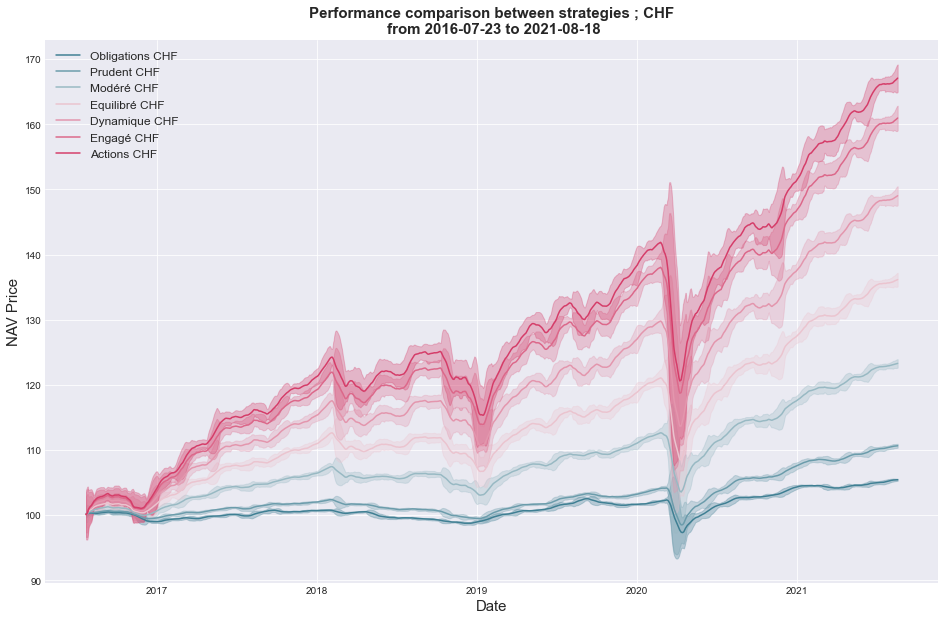

In [717]:
pp_port = pp_port_excel.copy()
window = 30
all_strat = get_all_strat(pp_port, curr='CHF')
colors = sns.diverging_palette(220, 0, n=len(all_strat)+2)
del colors[3:5]
fig = plt.figure(figsize=(16, 10))

for i, strat in enumerate(all_strat):
    df_weight = pp_port[pp_port.strategie == strat].drop(columns='strategie').drop_duplicates()
    df_weight = df_weight.pivot(index='histo_date', columns='No ISIN', values='weight').fillna(0)
    all_isin = list(df_weight.columns)
    data = data_excel.copy()
    data = data[all_isin]
    data = data.iloc[2000:]
    df_weight = pd.merge(data.drop(columns=data.columns), df_weight, how='left', left_index=True, right_index=True).fillna(method='bfill').dropna(how='all')
    data = data.loc[:df_weight.index[-1]]
    df_strat_price = (100 * (1 + data.pct_change().mul(df_weight).sum(axis=1).cumsum())).to_frame().rename(columns={0:'price'})
    df_strat_bollinger = get_conf_interval(df_strat_price)
    sns.lineplot(data=df_strat_bollinger, x=df_strat_bollinger.index, y='mean', lw=1.5, label=strat, color=colors[i])
    plt.fill_between(df_strat_bollinger.index, df_strat_price['bottom'], df_strat_bollinger['top'], color=colors[i], alpha=0.3)

plt.legend(fontsize=12)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NAV Price', fontsize=15)
plt.title('Performance comparison between strategies ; ' + curr + '\n from ' + str(df_strat_price.index.date[0]) + ' to ' + str(df_strat_price.index.date[-1]), 
          fontsize=15, fontweight='bold')
plt.grid()
plt.savefig('pp_output/performance_comparison.png')
plt.show()
    

In [718]:
strat = "Obligations CHF"

In [719]:
pp_port = pp_port_excel.copy()
pp_port = pp_port[pp_port.strategie == strat].drop(columns='strategie').drop_duplicates()
pp_port.head()

,No ISIN,histo_date,weight
0,SBWMSF3L Index,2019-10-11,0.0115
1,SBWMEU3L Index,2019-10-11,0.0035
2,SBWMUD3U Index,2019-10-11,-0.0250
3,CHFUSDCR Curncy,2019-10-11,0.0050
5,EURUSDCR Curncy,2019-10-11,0.0200


In [720]:
pp_port = pp_port.pivot(index='histo_date', columns='No ISIN', values='weight').fillna(0)
pp_port.head()

No ISIN,AURLNCHF CURNCY,BAC1TRUU Index,BCOMHFT Index,BXCHTRCH Index,CHF Curncy,CHFEURCR Curncy,CHFUSDCR Curncy,EMBC SW Equity,EURUSDCR Curncy,H00039CH Index,H03410CH Index,H20344CH Index,H30909CH Index,HFRXGLC Index,I02913JP Index,INSYBZE Index,JPYEURCR Curncy,LBEATREU Index,LEUPCBC SW Index,LF89TRCH Index,LF98TRUU Index,LGCPTRUU Index,LP02TREU Index,MRSGCAH LX Index,SBF14T Index,SBR4T Index,SBWG10U Index,SBWG13U Index,SBWGNSUU Index,SBWGNSZC Index,SBWMEU3L Index,SBWMJY3L Index,SBWMSF3L Index,SBWMUD3U Index,SF15T Index,SF51T Index,SWIIT Index,XGIUCHIV Index
histo_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-11,0.0,0.0882,0.0,0.0,0.025,0.0,0.005,0.0475,0.020,0.0647,0.072,0.0,0.00,0.0,0.0082,0.0241,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.3287,0.0481,0.0,0.0561,0.0481,0.0,0.0035,0.0,0.0115,-0.025,0.1122,0.0,0.0,0.0321
2019-11-13,0.0,0.0882,0.0,0.0,0.024,0.0,0.005,0.0475,0.019,0.0647,0.072,0.0,0.00,0.0,0.0082,0.0241,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.1844,0.0481,0.0,0.0561,0.0481,0.0,0.0030,0.0,0.0130,-0.024,0.2566,0.0,0.0,0.0321
2019-12-13,0.0,0.0882,0.0,0.0,0.024,0.0,0.005,0.0475,0.019,0.0647,0.072,0.0,0.00,0.0,0.0082,0.0241,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.1844,0.0481,0.0,0.0561,0.0481,0.0,0.0030,0.0,0.0130,-0.024,0.2566,0.0,0.0,0.0321
2020-01-16,0.0,0.0882,0.0,0.0,0.033,0.0,0.000,0.0475,0.033,0.0647,0.072,0.0,0.00,0.0,0.0082,0.0241,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.1844,0.0481,0.0,0.0561,0.0481,0.0,0.0000,0.0,0.0070,-0.033,0.2566,0.0,0.0,0.0321
2020-02-13,0.0,0.0888,0.0,0.0,0.018,0.0,0.000,0.0807,0.018,0.0484,0.072,0.0,0.01,0.0,0.0087,0.0242,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.1211,0.0484,0.0,0.0565,0.0484,0.0,0.0035,0.0,0.0185,-0.018,0.2421,0.0,0.0,0.0484


In [721]:
all_isin = list(pp_port.columns)
data = data_excel.copy()
data = data[all_isin]
data.head(2)

,AURLNCHF CURNCY,BAC1TRUU Index,BCOMHFT Index,BXCHTRCH Index,CHF Curncy,CHFEURCR Curncy,CHFUSDCR Curncy,EMBC SW Equity,EURUSDCR Curncy,H00039CH Index,H03410CH Index,H20344CH Index,H30909CH Index,HFRXGLC Index,I02913JP Index,INSYBZE Index,JPYEURCR Curncy,LBEATREU Index,LEUPCBC SW Index,LF89TRCH Index,LF98TRUU Index,LGCPTRUU Index,LP02TREU Index,MRSGCAH LX Index,SBF14T Index,SBR4T Index,SBWG10U Index,SBWG13U Index,SBWGNSUU Index,SBWGNSZC Index,SBWMEU3L Index,SBWMJY3L Index,SBWMSF3L Index,SBWMUD3U Index,SF15T Index,SF51T Index,SWIIT Index,XGIUCHIV Index
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-02,158.57,170.1060,81.9641,102.7815,0.9369,108.7062,118.5983,NaN,109.1003,218.4880,134.6393,116.0230,NaN,1343.71,120.89,NaN,89.7066,181.6301,139.99,195.2512,1210.18,195.0848,187.53,30.58,112.23,121.70,1282.939,573.7082,NaN,402.26,148.6304,103.5536,120.0113,155.7000,110.66,116.14,254.85,NaN
2011-01-03,158.57,171.1293,83.2361,102.7815,0.9352,107.9246,118.8138,NaN,110.0902,218.6385,134.6463,116.0817,NaN,1349.05,120.90,NaN,89.5790,181.6301,139.99,195.2512,1211.19,196.6348,187.53,30.57,112.25,121.72,1297.437,577.2739,NaN,402.81,148.6337,103.5540,120.0121,155.7011,110.68,116.19,253.52,NaN


In [581]:
df_weight = pd.merge(data.drop(columns=data.columns), pp_port, how='left', left_index=True, right_index=True).fillna(method='bfill').dropna(how='all')

In [582]:
data = data.loc[:df_weight.index[-1]]

In [585]:
df_strat_price = (100 * (1 + data.pct_change().mul(df_weight).sum(axis=1).cumsum())).to_frame().rename(columns={0:'price'})

In [637]:
window = 30

In [638]:
df_strat_bollinger = get_conf_interval(df_strat_price)
df_strat_bollinger.head()

,price,mean,std,bottom,top
Dates,,,,,
2011-08-13,94.099140,98.580937,5.751150,92.829787,104.332087
2011-08-14,94.099140,98.368338,5.929867,92.438471,104.298206
2011-08-15,95.190753,98.192127,5.984495,92.207632,104.176621
2011-08-16,96.086072,98.045759,5.968012,92.077747,104.013771
2011-08-17,96.000858,97.898364,5.943463,91.954901,103.841827


df_indice_bollinger = 100 * (1 + data[[indice]].pct_change().cumsum().fillna(0))
df_indice_bollinger = get_conf_interval(df_indice)

In [639]:
indice_list = ['SPI Index', 'SF15T Index']
color_list = ['darkorange', 'firebrick', 'green']

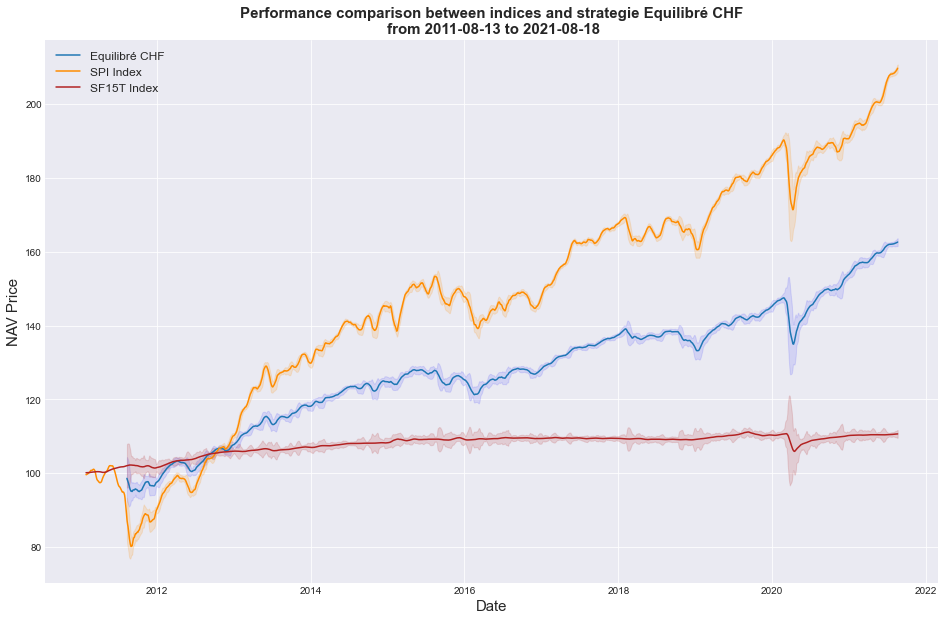

In [642]:
fig = plt.figure(figsize=(16, 10))
ax1 = sns.lineplot(data=df_strat_bollinger, x=df_strat_bollinger.index, y='mean', lw=1.5, label=strat)
ax2 = plt.fill_between(df_strat_bollinger.index, df_strat_price['bottom'], df_strat_bollinger['top'], color='b', alpha=.1)
for i, indice in enumerate(indice_list):
    color = color_list[i]
    df_indice_bollinger = pd.DataFrame()
    df_indice_bollinger = (100 * (1 + data[indice].pct_change().cumsum().fillna(0))).to_frame()
    df_indice_bollinger = get_conf_interval(df_indice_bollinger)
    sns.lineplot(data=df_indice_bollinger, x=df_indice_bollinger.index, y='mean', lw=1.5, label=indice, color=color)
    plt.fill_between(df_indice_bollinger.index, df_indice_bollinger['bottom'], df_indice_bollinger['top'], alpha=.15, color=color)
plt.legend(fontsize=12)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NAV Price', fontsize=15)
plt.title('Performance comparison between indices and strategie ' + strat + '\n from ' + str(df_strat_price.index.date[0]) + ' to ' + str(df_strat_price.index.date[-1]), 
          fontsize=15, fontweight='bold')
plt.grid()
plt.savefig('pp_output/indice_comparison_' + strat + '.png')
plt.show()


### DRAFT

for i, (date, df) in enumerate(df_port_diff.groupby(level=0, group_keys=False)):
    df_top = df.nlargest(5, 'weight_diff_abs')['weight_diff'].to_frame().rename(columns={'weight_diff':'Top 5 movers'})
    string_date = date.to_pydatetime().strftime("%d.%m.%Y")
    dfi.export(df_top, 'pp_output/TopMovers_' + string_date + '_' + str.replace(strat, ' ', '') + '.png')
    

df_port_diff_grouped = df_port_diff.groupby(level=0, group_keys=False).apply(lambda x: x.nlargest(5, 'weight_diff_abs'))['weight_diff'].to_frame()

count = 0
count_temp = 0

for i, (date, df) in enumerate(df_port_diff.groupby(level=0, group_keys=False)):
    df_top = df.nlargest(5, 'weight_diff_abs')['weight_diff'].to_frame().rename(columns={'weight_diff':'Top 5 movers'})
    if count == 0:
        df0 = df_top
        if i == len(df_port_diff.groupby(level=0)) -1 :
            df0_styler = df0.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
            # display_html(df0_styler._repr_html_(), raw=True)
        count_temp += 1
    if count == 1:
        df1 = df_top
        if i == len(df_port_diff.groupby(level=0)) -1 :
            df1_styler = df1.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
            # display_html(df0_styler._repr_html_() + df1_styler._repr_html_(), raw=True)
        count_temp += 1
    if count == 2:
        df2 = df_top
        df0_styler = df0.style.format(formatter={'Top 5 movers': "{:.2f}", 'date': "{:%Y/%m}"}).set_table_attributes("style='display:inline'")
        df1_styler = df1.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
        df2_styler = df2.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
        # display_html(df0_styler.render() + df1_styler._repr_html_() + df2_styler.render(), raw=True)
        count_temp = 0
    count = count_temp

In [594]:
pp_port = excel_to_csv('PP_data/pp_histo.xlsx', 'PP')
pp_port.drop(columns='portfolio', inplace=True)
pp_port['No ISIN'].replace({
    
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'LEUPCBC SW Index',
    'Cat Bond EUR': 'LEUPCBE SW Index'
    
    }, inplace=True)

In [595]:
ALL = pd.DataFrame(pp_port['No ISIN'].unique(), columns=['No ISIN'])

In [596]:
ALL

,No ISIN
0,SBWMSF3L Index
1,SBWMEU3L Index
2,SBWMUD3U Index
3,CHFUSDCR Curncy
4,EURUSDCR Curncy
...,...
115,M0CHHUSD Index
116,M0UKHUSE Index
117,M0EMHUSR Index
118,USDJPYCR Curncy


In [597]:
data = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])

In [598]:
data.rename(columns = { data.columns[0]: "Dates" }, inplace = True)
data['Dates'] = pd.to_datetime(data['Dates'], yearfirst=True, format="%d/%m/%Y")
data = data.fillna(method='ffill')
data.index = data['Dates']
data = data.drop(columns=['Dates', 'HYBRIDCHF'])

In [599]:
data = data[ALL['No ISIN']]

KeyError: "['HFRXGLC Index', 'LE10TREU Index', 'M0EMHCHF Index', 'LF89TREH Index', 'LGCPTRUU Index', 'M0UKHEUR Index', 'BCOMHET Index', 'H30909EU INDEX', 'H02913EU Index', 'LG30TRCH Index', 'Contrepartie CHF', 'LECPTREU Index', 'HFRXGLE Index', 'H03410CH Index', 'HYBRIDCHF', 'SF51T Index', 'LG30TREH Index', 'SBNM13U Index', 'Contrepartie EUR', 'Contrepartie USD', 'H20344CH Index', 'SBR4T Index', 'BXCHTRCH Index', 'SBNM10EC Index', 'H20344EU Index', 'M0CHHEUR Index', 'SBNMEC Index', 'LF89TRCH index', 'M0UKHCHF Index', 'LE13TREU Index', 'H30909US Index', 'SBWGNSUU Index', 'aurlneur curncy', 'SBWGNSZC Index', 'SWIIT Index', 'SBWG10CH Index', 'SBWG10U INDEX', 'SBF14T Index', 'H31413EU Index', 'BXEMTRUU Index', 'BCOMHFT Index', 'SMCI Index', 'aurlnchf curncy', 'M7EMMC Index', 'H30909CH Index', 'SF15T Index', 'SBNMUU Index', 'SBWG13U INDEX', 'M1CXAMPF Index', 'M7CXLBPA Index', 'JPGCHFCP Index'] not in index"

In [314]:
all_isin = get_all_isin(pp_port, curr='USD', histo_date='2021-08-18')

In [319]:
portfolio = get_weight(pp_port, 'Dynamique USD', '2021-08-18').reset_index(drop=True)

In [320]:
portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0)
portfolio

,No ISIN,weight
0,SBWMUD3U Index,0.0220
1,SBWMEU3L Index,0.0150
2,SBWMSF3L Index,0.0130
3,LBUSTRUU Index,0.0295
4,LU13TRUU Index,0.0491
5,LU10TRUU Index,0.0038
6,LUACTRUU Index,0.0165
7,Inflation Bond USD,0.0063
8,UCBIFX02 Index,0.0063
9,LG30TRUH Index,0.0188


In [321]:
portfolio['No ISIN'].replace({
    
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat bond USD': 'LEUPCBU SW Index',
    'Cat bond CHF': 'LEUPCBC SW Index',
    'Cat bond EUR': 'LEUPCBE SW Index'
    
    }, inplace=True)

In [210]:
portfolio = portfolio[~portfolio['No ISIN'].isin(['HFRXGLC Index', 'SWIIT Index', 'SF15T Index', 
 'M0EMHCHF Index', 'SBR4T Index', 'H20344CH Index', 'BXCHTRCH Index', 
 'SBF14T Index', 'BCOMHFT Index', 'LG30TRCH Index', 
 'aurlnchf curncy', 'M0UKHCHF Index', 'UCBIFX28 Index', 'SF51T Index'])]

In [246]:
portfolio.weight = portfolio.weight / np.sum(portfolio.weight)
portfolio

,No ISIN,weight
0,SBWMSF3L Index,0.072982
5,XGIUCHIV Index,0.009196
10,SPI Index,0.319078
12,NE734804 Index,0.074296
13,NDDLUK Index,0.025690
15,NDDLUS Index,0.159831
16,M0USHCHF Index,0.011677
17,NDDLCA Index,0.013867
18,NDDUPXJ Index,0.019705
19,NDDLJN Index,0.040140


In [247]:
port_weights = np.array(portfolio['weight'])

In [322]:
data = data[list(portfolio['No ISIN'])]

KeyError: "['M0EMHUSR Index', 'SBWMUD3U Index', 'H20344US Index', 'SBNUC Index', 'M0UKHUSE Index', 'MSDEEMUN Index', 'SBWMEU3L Index', 'XAUUSD Curncy', 'LU13TRUU Index', 'HFRXGL Index', 'M0USHEUR Index', 'BCOMTR Index', 'SBNU10C Index', 'MORSCUA LX Index', 'LBUSTRUU Index', 'LG30TRUH Index', 'LU10TRUU Index', 'LUACTRUU Index', 'TIPIV Index'] not in index"

In [219]:
data.head()

,SBWMSF3L Index,XGIUCHIV Index,SPI Index,NE734804 Index,NDDLUK Index,NDDLUS Index,M0USHCHF Index,NDDLCA Index,NDDUPXJ Index,NDDLJN Index,NDUEEGF Index,M1USMC Index,JCGMMUN Index
Dates,,,,,,,,,,,,,
2011-01-02,120.0113,NaN,5893.97,NaN,7074.46,2985.580,106.04,4539.264,4502.476,936.456,434.891,919.56,1364.80
2011-01-03,120.0121,NaN,5790.62,NaN,6989.44,2984.848,105.98,4545.396,4502.579,936.456,437.016,917.63,1373.12
2011-01-04,120.0140,NaN,5842.19,NaN,6989.44,3018.258,107.17,4545.396,4514.319,936.456,441.669,928.66,1378.68
2011-01-05,120.0146,NaN,5844.27,NaN,7127.29,3013.774,107.03,4531.386,4489.800,950.050,442.264,921.54,1373.65
2011-01-06,120.0152,NaN,5852.35,NaN,7164.32,3028.716,107.60,4531.005,4453.805,949.351,440.720,925.44,1360.25


In [248]:
port_sharp = sigma_to_sharp(port_weights, returns_annual, cov_annual)